In [1]:
import math, random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import torch.cuda as cuda

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Use Cuda

In [3]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

# Judger

In [4]:
ini_map = np.array([[0, 0, 10, 1, 5, 1, 20, 0, 0],
                  [0, 0, 0, 1, 2, 1, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0, 0],
                  [1, 1, 1, 1, 1, 1, 1, 1, 1],
                  [0, 0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 1, 2, 1, 0, 0, 0],
                  [0, 0, -20, 1, 5, 1, -10, 0, 0]])
ini_tankposx = np.array([[0, 0], [8, 8]])
ini_tankposy = np.array([[2, 6], [6, 2]])
delta = np.array([[-1, 0], [0, -1], [-1, 0], [0, -1], [], [0, 1], [1, 0], [0, 1], [1, 0]])
tank_transform = [0, 0, 0, 0, -10, -20, 10, 20]

class Environment(object):
    def __init__(self):
        #空：0，砖：1，钢：2，基地：3, 甲方坦克：4，5，乙方坦克：6，7
        self.state = ini_map.copy()
        self.tank_posx = ini_tankposx.copy()
        self.tank_posy = ini_tankposy.copy()
    def reset(self, rd_threshold):
        self.state = ini_map.copy()
        self.tank_posx = ini_tankposx.copy()
        self.tank_posy = ini_tankposy.copy()
        for i in range(9):
            for j in range(9):
                if self.state[i][j] == 0:
                    self.state[i][j] = (np.random.random() > rd_threshold)
        state_temp = self.state.copy()
        state_temp[np.reshape(self.tank_posx, (-1)), np.reshape(self.tank_posy, (-1))] = [-10, -20, 10, 20]
        #print(self.state)
        return [self.state.copy(), np.flip(np.flip(state_temp, 0), 1)]
    def InMap(self, pos):
        if (pos[0] >= 0 and pos[0] < 9 and pos[1] >= 0 and pos[1] < 9):
            return True
        return False
    def step(self, action):
        """action编号：
        0：上移
        1：左移
        2：上射
        3：左射
        4：静止
        5：右射
        6：下射
        7：右移
        8：下移
        """
        #Player0
        action00 = int(action[0] / 9)
        action01 = action[0] % 9
        reward0 = 0
        done0 = 0
        nextpos00 = np.array([self.tank_posx[0][0], self.tank_posy[0][0]])
        nextpos01 = np.array([self.tank_posx[0][1], self.tank_posy[0][1]])
        obj_shot00 = np.array([-1, -1])
        obj_shot01 = np.array([-1, -1])
        
        #Tank0
        if (nextpos00[0] != -1 and action00 != 4): #tank isn't dead
            if (action00 < 2 or action00 > 6): #move
                reward0 += (action00 == 8) * 0.4 - (action00 == 0) * 0.4
                nextpos00 += delta[action00]
                if (not(self.InMap(nextpos00)) or (self.state[nextpos00[0], nextpos00[1]] != 0)):
                    self.state[self.tank_posx[0][0], self.tank_posy[0][0]] = 0
                    self.tank_posx[0][0] = -1
                    self.tank_posy[0][0] = -1
                    reward0 -= 1
                    done0 = 1
        
        #Tank1
        if (nextpos01[0] != -1 and action01 != 4):
            if (action01 < 2 or action01 > 6): #move
                reward0 += (action01 == 8) * 0.4 - (action01 == 0) * 0.4
                nextpos01 += delta[action01]
                if (not(self.InMap(nextpos01)) or self.state[nextpos01[0], nextpos01[1]] != 0):
                    self.state[self.tank_posx[0][1], self.tank_posy[0][1]] = 0
                    self.tank_posx[0][1] = -1
                    self.tank_posy[0][1] = -1
                    reward0 -= 1
                    done0 = 1
         
        #Player1
        action10 = 8 - int(action[1] / 9)
        action11 = 8 - action[1] % 9
        reward1 = 0
        done1 = 0
        nextpos10 = np.array([self.tank_posx[1][0], self.tank_posy[1][0]])
        nextpos11 = np.array([self.tank_posx[1][1], self.tank_posy[1][1]])
        obj_shot10 = np.array([-1, -1])
        obj_shot11 = np.array([-1, -1])
        
        #Tank0
        if (nextpos10[0] != -1 and action10 != 4): #tank isn't dead
            if (action10 < 2 or action10 > 6): #move
                reward1 += (action10 == 0) * 0.4 - (action10 == 8) * 0.4
                nextpos10 += delta[action10]
                if (not(self.InMap(nextpos10)) or self.state[nextpos10[0], nextpos10[1]] != 0):
                    self.state[self.tank_posx[1][0], self.tank_posy[1][0]] = 0
                    self.tank_posx[1][0] = -1
                    self.tank_posy[1][0] = -1
                    reward1 -= 1
                    done1 = 1
        
        #Tank1
        if (nextpos11[0] != -1 and action11 != 4):
            if (action11 < 2 or action11 > 6): #move
                reward1 += (action11 == 0) * 0.4 - (action11 == 8) * 0.4
                nextpos11 += delta[action11]
                if (not(self.InMap(nextpos11)) or self.state[nextpos11[0], nextpos11[1]] != 0):
                    self.state[self.tank_posx[1][1], self.tank_posy[1][1]] = 0
                    self.tank_posx[1][1] = -1
                    self.tank_posy[1][1] = -1
                    reward1 -= 1
                    done1 = 1
        
        
        #State Update
        nextpos = [[nextpos00, nextpos01], [nextpos10, nextpos11]]
        for i in range(2):
            for j in range(2):
                if (self.tank_posx[i][j] != -1):
                    self.state[self.tank_posx[i][j], self.tank_posy[i][j]], self.state[nextpos[i][j][0], nextpos[i][j][1]] = self.state[nextpos[i][j][0], nextpos[i][j][1]], self.state[self.tank_posx[i][j], self.tank_posy[i][j]] #swap
                    self.tank_posx[i][j], self.tank_posy[i][j] = nextpos[i][j][0], nextpos[i][j][1]
        #print(self.state)
        
        #Shoot
        #Player0 
        #Tank0
        if (nextpos00[0] != -1 and action00 != 4): #not dead
            if (action00 > 1 and action00 < 7): #shoot
                temp_pos = nextpos00 + delta[action00]
                while (self.InMap(temp_pos)):
                    #print(temp_pos)
                    if (self.state[temp_pos[0], temp_pos[1]] != 0):
                        obj_shot00 = temp_pos.copy()
                        break
                    temp_pos += delta[action00]
        
        #Tank1
        if (nextpos01[0] != -1 and action01 != 4):
            if (action01 > 1 and action01 < 7): #shoot
                temp_pos = nextpos01 + delta[action01]
                while (self.InMap(temp_pos)):
                    if (self.state[temp_pos[0], temp_pos[1]] != 0):
                        obj_shot01 = temp_pos.copy()
                        break
                    temp_pos += delta[action01]
        
        #Player1
        #Tank0
        if (nextpos10[0] != -1 and action10 != 4): #not dead
            if (action10 > 1 and action10 < 7): #shoot
                temp_pos = nextpos10 + delta[action10]
                while (self.InMap(temp_pos)):
                    if (self.state[temp_pos[0], temp_pos[1]] != 0):
                        obj_shot10 = temp_pos.copy()
                        #print(obj_shot10)
                        break
                    temp_pos += delta[action10]
        
        #Tank1
        if (nextpos11[0] != -1 and action11 != 4): #not dead
            if (action11 > 1 and action11 < 7): #shoot
                temp_pos = nextpos11 + delta[action11]
                while (self.InMap(temp_pos)):
                    if (self.state[temp_pos[0], temp_pos[1]] != 0):
                        obj_shot11 = temp_pos.copy()
                        #print(obj_shot11)
                        break
                    temp_pos += delta[action11]
         
        #Anything got shot?
        obj_shot = np.array([[obj_shot00, obj_shot01], [obj_shot10, obj_shot11]])
        for i in range(2):
            for j in range(2):
                if (obj_shot[i][j][0] != -1):
                    if (abs(self.state[obj_shot[i][j][0], obj_shot[i][j][1]]) >= 10): #Tank got shot
                        tanknum = self.state[obj_shot[i][j][0], obj_shot[i][j][1]]
                        if (obj_shot[int(tanknum < 0)][abs(tanknum) > 15][0] != self.tank_posx[i][j] or
                            obj_shot[int(tanknum < 0)][abs(tanknum) > 15][1] != self.tank_posy[i][j]): #没有对射
                            reward0 += (tanknum < 0) * 4 - 2
                            reward1 += (tanknum > 0) * 4 - 2

                            self.state[obj_shot[i][j][0], obj_shot[i][j][1]] = 0
                            self.tank_posx[int(tanknum < 0)][abs(tanknum) > 15] = -1
                            self.tank_posy[int(tanknum < 0)][abs(tanknum) > 15] = -1
                    elif (self.state[obj_shot[i][j][0], obj_shot[i][j][1]] == 5):
                        #Base got shot
                        reward0 += (obj_shot[i][j][0] == 8) * 4 - 2
                        reward1 += (obj_shot[i][j][0] == 0) * 4 - 2
                        done0 = 1
                    elif (self.state[obj_shot[i][j][0], obj_shot[i][j][1]] != 2):
                        self.state[obj_shot[i][j][0], obj_shot[i][j][1]] = 0
                    
        
        
        if (self.tank_posx[0][0] == -1 and self.tank_posx[0][1] == -1):
            done0 = 1
            #reward0 -= 1
            #reward1 += 1
        if (self.tank_posx[1][0] == -1 and self.tank_posx[1][1] == -1):
            done1 = 1
            #reward0 += 1
            #reward1 -= 1
        
        done = (done0 or done1)
        
        #return
        state_temp = self.state.copy()
        for i in range(2):
            for j in range(2):
                if (self.tank_posx[i][j] != -1):
                    state_temp[self.tank_posx[i][j], self.tank_posy[i][j]] *= -1
        state_temp = np.flip(np.flip(state_temp, 0), 1)
        
        return [[self.state.copy(), state_temp], [reward0, reward1], done]

# Replay Buffer

In [5]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        #state      = np.expand_dims(state, 0)
        #next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        
        #print(np.stack(state).shape)
        return np.stack(state), action, reward, np.stack(next_state), done
    
    def __len__(self):
        return len(self.buffer)

# Epsilon Greedy Exploration

In [6]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 200000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

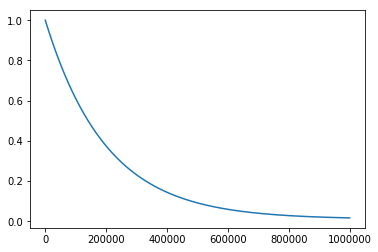

In [7]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

# Deep Q Network

In [8]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [9]:
channel_1 = 64
channel_2 = 32
channel_3 = 16

shoot_num = [2, 3, 5, 6]

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(1, channel_1, 3, padding = 1),
            nn.BatchNorm2d(channel_1),
            nn.ReLU(),
            nn.Conv2d(channel_1, channel_2, 3, padding = 1),
            nn.BatchNorm2d(channel_2),
            nn.ReLU(),
            nn.Conv2d(channel_2, channel_3, 3, padding = 1),
            Flatten(),
            nn.Dropout(),
            nn.Linear(16 * 9 * 9, 81) #number of operations
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon, if_can_shoot0, if_can_shoot1):
        if random.random() > epsilon:
            state_temp   = torch.cuda.FloatTensor(state.copy())#, requires_grad = False)
            q_value = self.forward(state_temp)
            if (not if_can_shoot0):
                for num in shoot_num:
                    for j in range(9):
                        q_value[:, num * 9 + j] = -100
            if (not if_can_shoot1):
                for i in range(9):
                    for num in shoot_num:
                        q_value[:, i * 9 + num] = -100
            action  = torch.argmax(q_value, dim = 1).item()
        else:
            action = random.randrange(81) #number of operations
        return action

# Loss

In [10]:
def compute_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = cuda.FloatTensor(np.expand_dims(state, axis = 1))
    next_state = cuda.FloatTensor(np.expand_dims(next_state, axis = 1))#, requires_grad = False)
    #action     = cuda.LongTensor(action)
    #reward     = cuda.FloatTensor(reward)
    #done       = cuda.FloatTensor(done)
    
    q_values      = model(state)
    next_q_values = model(next_state)

    q_value = q_values[range(batch_size), action]
    next_q_value, _ = torch.max(next_q_values, dim = 1)
    expected_q_value = cuda.FloatTensor(reward)+ gamma * next_q_value.data * cuda.FloatTensor(1 - np.array(done))
    
    loss = (cuda.FloatTensor(q_value) - expected_q_value).pow(2).mean() 
        
    optimizer.zero_grad()
    #for param in model.parameters():
    #    print(param)
    loss.backward()
    optimizer.step()
    
    return loss

In [11]:
q_value_his = []

def plot(frame_idx, valid_set, losses, flag, all_rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    if (flag):
        plt.subplot(131)
        plt.title("Q Value")
        state = cuda.FloatTensor(np.expand_dims(valid_set, axis = 1))
        q_values = model(state)
        q_value, _ = torch.max(q_values, dim = 1)
        q_value_his.append(q_value.mean().data[0])
        plt.plot(q_value_his)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title('rewards')
    plt.plot(all_rewards)
    plt.show()

# Train

In [12]:
def If_Can_Shoot_Next(a):
    if (a > 1 and a < 7 and a != 4):
        return False
    return True

In [13]:
choice = [0, 1, 7, 8]
delta2 = np.array([[-1, 0], [0, -1], [0, 1], [1, 0]])
def RandomWalk(state, pos0, pos1):
    pos0 = 8 - pos0 #side1需要反转
    pos1 = 8 - pos1
    choice0 = []
    for i in range(4):
        new_pos = pos0 + delta2[i]
        if (env.InMap(new_pos) and state[new_pos[0], new_pos[1]] == 0):
            choice0.append(choice[i])
    if (len(choice0) == 0):
        choice0.append(4)
    choice1 = []
    for i in range(4):
        new_pos = pos1 + delta2[i]
        if (env.InMap(new_pos) and state[new_pos[0], new_pos[1]] == 0):
            choice1.append(choice[i])
    if (len(choice1) == 0):
        choice1.append(4)
    
    return np.random.choice(choice0) * 9 + np.random.choice(choice1)

In [14]:
learning_rate = 0.000001
model = DQN()
model = model.cuda()

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

replay_buffer = ReplayBuffer(1000000)

KeyboardInterrupt: 

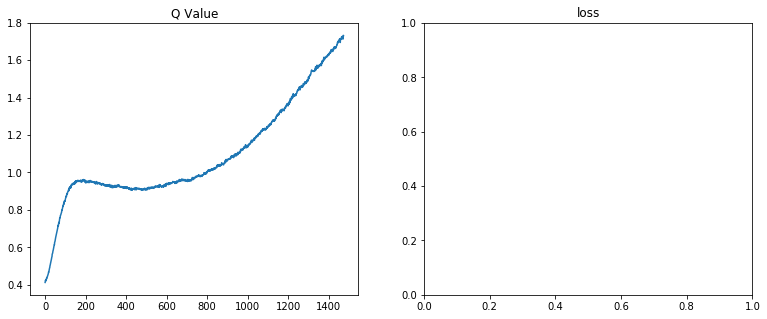

In [21]:
#plt.clf()

num_frames = 300000
batch_size = 32
gamma      = 1 #reward衰减率

#losses = []
#all_rewards = []
#action_his = []
#done_his = []
#state_his = []
#episode_reward = 0
#plot_every = 100
#replay_initial = 1000
#test_flush_every = 5000
if_can_shoot = [[1, 1], [1, 1]]

#env = Environment()
state = env.reset(np.random.random() / 2 + 0.5) #[state[0], state[1]]
#valid_set = np.zeros((0))
#flag = False

for frame_idx in range(80000, num_frames):
    model.train()
    if (frame_idx % 10000 == 0): #适时刷新一下rewards图。。不然看不清 = =
        all_rewards = []
    
    if ((frame_idx - 1500) % test_flush_every == 0):
        valid_set, _, __, ___, ____ = replay_buffer.sample(1000)
        flag = True
        
    
    epsilon = epsilon_by_frame(frame_idx)
    state_temp0 = np.expand_dims(np.expand_dims(state[0], axis = 0), axis = 0)
    state_temp1 = np.expand_dims(np.expand_dims(state[1], axis = 0), axis = 0)
    #action = [model.act(state_temp0, epsilon, if_can_shoot[0][0], if_can_shoot[0][1]), RandomWalk(state[1].copy(), np.array([env.tank_posx[1][0], env.tank_posy[1][0]]), np.array([env.tank_posx[1][1], env.tank_posy[1][1]]))] #先不要对抗，只有一边在学习
    action = [model.act(state_temp0, epsilon, if_can_shoot[0][0], if_can_shoot[0][1]), model.act(state_temp1, epsilon, if_can_shoot[1][0], if_can_shoot[1][1])]
    #前一帧也会影响这次行动，需要加入前一帧对方是否发射炮弹的信息(unfinished)
    #要鼓励移动
    #if (np.random.random() > 0.5):
    #    temp_ran0 = np.random.random()
    #    temp_ran1 = np.random.random()
    #    action[0] = ((temp_ran0  < 0.75) * 8 + (temp_ran0 > 0.75 and temp_ran0 < 0.9) * 1 + (temp_ran0 > 0.9 and temp_ran0 < 0.95) * 7) * 9 + ((temp_ran1  < 0.75) * 8 + (temp_ran1 > 0.75 and temp_ran1 < 0.9) * 7 + (temp_ran1 > 0.9 and temp_ran1 < 0.95) * 1)
    #if (np.random.random() > 0.5):
    #    temp_ran0 = np.random.random()
    #    temp_ran1 = np.random.random()
    #    action[1] = ((temp_ran0  < 0.75) * 8 + (temp_ran0 > 0.75 and temp_ran0 < 0.9) * 1 + (temp_ran0 > 0.9 and temp_ran0 < 0.95) * 7) * 9 + ((temp_ran1  < 0.75) * 8 + (temp_ran1 > 0.75 and temp_ran1 < 0.9) * 7 + (temp_ran1 > 0.9 and temp_ran1 < 0.95) * 1)
    #if (int(action[0] / 9) == 4 and np.random.random() > 0.5):
    #    action[0] = action[0] % 9 + np.random.choice([2, 3, 5, 6], p = [0.05, 0.1, 0.1, 0.75])
    #if (action[0] % 9 == 4 and np.random.random() > 0.5):
    #    action[0] += (-(action[0] % 9) + np.random.choice([2, 3, 5, 6], p = [0.05, 0.1, 0.1, 0.75]))
    #if (int(action[1] / 9) == 4 and np.random.random() > 0.5):
    #    action[1] = action[1] % 9 + np.random.choice([2, 3, 5, 6], p = [0.05, 0.1, 0.1, 0.75])
    #if (action[1] % 9 == 4 and np.random.random() > 0.5):
    #    action[1] += (-(action[1] % 9) + np.random.choice([2, 3, 5, 6], p = [0.05, 0.1, 0.1, 0.75]))
        
    #print(action)
    
    if_can_shoot = [[If_Can_Shoot_Next(int(action[0] / 9)), If_Can_Shoot_Next(action[0] % 9)], [If_Can_Shoot_Next(int(action[1] / 9)), If_Can_Shoot_Next(action[1] % 9)]]
    next_state, reward, done = env.step(action)
    action_his.append(action[0])
    done_his.append(done)
    
    replay_buffer.push(state[0], action[0], reward[0], next_state[0], done)
    replay_buffer.push(state[1], action[1], reward[1], next_state[1], done)
    
    state = next_state
    #state_his.append(state[0])
    episode_reward += reward[0]
    
    if done:
        state = env.reset(np.random.random() / 2 + 0.5) #0.25概率是砖块
        #state_his.append(state[0])
        all_rewards.append(episode_reward)
        episode_reward = 0
        if_can_shoot = [[0, 0], [0, 0]]
        
    if len(replay_buffer) > replay_initial:
        loss = compute_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % plot_every == 0:
        plot(frame_idx, valid_set, losses, flag, all_rewards)

In [22]:
torch.save(model, 'model3.2_220000_0.4.pkl')

E:\Anaconda3\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type DQN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Anaconda3\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [13]:
plt.cla()
plt.clf()

<Figure size 432x288 with 0 Axes>

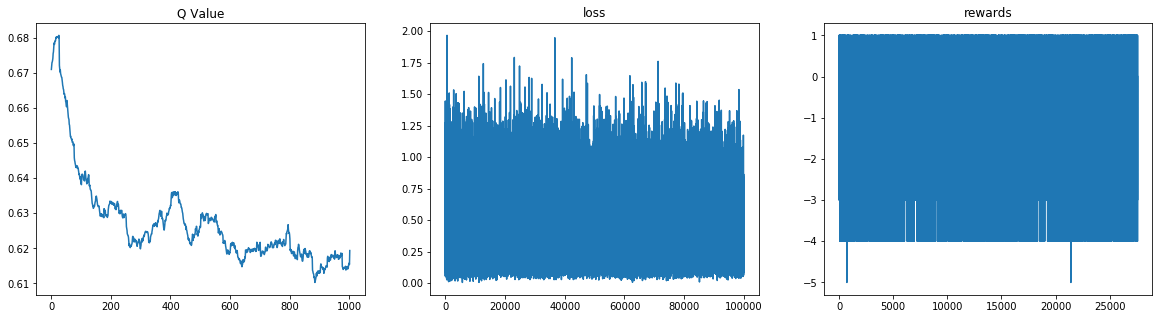

In [15]:
#optimizer = optim.Adam(model.parameters(), lr = 0.0000001)
optimizer = optim.Adam(model.parameters(), lr = 0.0000001)
#replay_buffer = ReplayBuffer(500000)#清空回放区


num_frames = 50000
batch_size = 32
gamma      = 0.95 #reward衰减率

losses = []
all_rewards = []
action_his = []
done_his = []
state_his = []
episode_reward = 0
plot_every = 100
replay_initial = 1000
test_flush_every = 5000

env = Environment()
state = env.reset(1) #[state[0], state[1]]
valid_set = np.zeros((0))
flag = False

for frame_idx in range(100000, 200000):
    #model.train()
    
    if ((len(replay_buffer.buffer) - 3000) % test_flush_every == 0):
        valid_set, _, __, ___, ____ = replay_buffer.sample(1000)
        flag = True
        
    
    epsilon = epsilon_by_frame(frame_idx)
    state_temp0 = np.expand_dims(np.expand_dims(state[0], axis = 0), axis = 0)
    state_temp1 = np.expand_dims(np.expand_dims(state[1], axis = 0), axis = 0)
    #action = [model.act(state_temp0, epsilon), 40] #先不要对抗，只有一边在学习
    action = [model.act(state_temp0, epsilon + 0.3), model.act(state_temp1, epsilon + 0.3)]
    #print(action)
    
    next_state, reward, done = env.step(action)
    action_his.append(action[0])
    done_his.append(done)
    
    #print("!")
    replay_buffer.push(state[0], action[0], reward[0], next_state[0], done)
    replay_buffer.push(state[1], action[1], reward[1], next_state[1], done)
    
    state = next_state
    episode_reward += reward[0]
    
    if done:
        state = env.reset(0.75)
        #state_his.append(state[0])
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % plot_every == 0:
        plot(frame_idx, valid_set, losses, flag, all_rewards)

In [16]:
torch.save(model, 'model_200000.pkl')

E:\Anaconda3\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type DQN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Anaconda3\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
for i in range(9):
    action_count = ((np.array(action_his)) % 9 == i)
    print(i, np.count_nonzero(action_count) / len(action_his))

0 0.0786781902739321
1 0.0797938116616038
2 0.08810048657221968
3 0.08022393075082664
4 0.1443116750450281
5 0.09897443479663431
6 0.08697814457377886
7 0.08197128955079437
8 0.26096803677518216


In [24]:
print(done_his)

[1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 

In [58]:
torch.save(model, 'model_50000.pkl')

E:\Anaconda3\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type DQN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Anaconda3\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
